# Occupancy

In [81]:
from pathlib import Path
import configparser
from utils import ProdigyLoader
from perShelfPredictor import PerShelfChillerPredictor, PredictedShelf
from shelfSettings import StoreManager
from lensCorrector import LensCorrector

from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import cv2
from matplotlib import pyplot as plt
from loguru import logger
import sys

In [2]:
loader = ProdigyLoader()
cfg = configparser.ConfigParser()
cfg.read('inference.ini')
shelf_model_path = Path(cfg['DEFAULT']['shelf_model_path'])
bottle_model_path = Path(cfg['DEFAULT']['bottle_model_path'])
brand_models_dir = Path(cfg['DEFAULT']['brand_models_dir'])
volume_model_path = Path(cfg['DEFAULT']['volume_model_path'])
bottle_model_threshold = float(cfg['DEFAULT']['bottle_model_threshold'])

predictor = PerShelfChillerPredictor(shelf_model_path=shelf_model_path, bottle_model_path=bottle_model_path, 
                                     brand_models_dir=brand_models_dir, volume_model_path=volume_model_path, 
                                     shelf_clip_index=5, bottle_model_threshold=bottle_model_threshold, 
                                     fixed_width_transform=True, debug=False)        

STORE_MAPPER_WITHOUT_EXCEPTIONS = StoreManager(raise_exception=False)

2024-09-18 10:23:01.501 | INFO     | segmentationInference:__init__:332 - Loading model from: ../models/shelf_model/model/shelf_model.pth to cuda


[09/18 10:23:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/shelf_model/model/shelf_model.pth ...


2024-09-18 10:23:02.165 | INFO     | segmentationInference:__init__:332 - Loading model from: ../models/bottle_model/model/bottle_model.pth to cuda


[09/18 10:23:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/bottle_model/model/bottle_model.pth ...


2024-09-18 10:23:03.053 | INFO     | classificationInference:__init__:57 - Loaded model: ../models/PETClassification.pth with categories: ['7Up', 'AquafinaWater', 'BisleriWater', 'Charged', 'Coke', 'DukeSoda', 'Fanta', 'KinleySoda', 'KinleyWater', 'Limca', 'Maaza', 'MinuteMaid', 'Mirinda', 'Pepsi', 'RimZim', 'Slice', 'Sprite', 'Sting', 'StingRed', 'SunriseWater', 'ThumsUp', 'pet'] to: cuda:0
2024-09-18 10:23:03.313 | INFO     | classificationInference:__init__:57 - Loaded model: ../models/CanClassification.pth with categories: ['7Up', 'Coke', 'CokeZero', 'DietCoke', 'Fanta', 'Limca', 'Mirinda', 'Monster', 'Pepsi', 'PepsiZero', 'Predator', 'RedBull', 'Sprite', 'ThumsUp', 'can'] to: cuda:0
2024-09-18 10:23:03.565 | INFO     | classificationInference:__init__:57 - Loaded model: ../models/RGBClassification.pth with categories: ['Coke', 'Fanta', 'Limca', 'Maaza', 'Sprite', 'ThumsUp', 'rgb'] to: cuda:0
2024-09-18 10:23:03.819 | INFO     | classificationInference:__init__:57 - Loaded model: .

In [3]:
anno_dir = Path("/home/akshay/workspace/labelling/coke/datasets/exported/accuracy/September-02/")

In [4]:
files = sorted(list(anno_dir.glob("*shelf*.jsonl")))
files

[PosixPath('/home/akshay/workspace/labelling/coke/datasets/exported/accuracy/September-02/accuracy_shelf-July16-July31-Set49-batch00-prashant.jsonl'),
 PosixPath('/home/akshay/workspace/labelling/coke/datasets/exported/accuracy/September-02/accuracy_shelf-July16-July31-Set49-batch01-prashant.jsonl')]

In [5]:
lens_corrector = LensCorrector()
json_dicts, labels = loader.load(files[0])

In [6]:
d = json_dicts[0]

In [181]:
class DepthPredictor:
    def __init__(self):
        self.image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")
        self.model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf")        
        cfg = configparser.ConfigParser()
        cfg.read('inference.ini')

        shelf_model_path = Path(cfg['DEFAULT']['shelf_model_path'])
        bottle_model_path = Path(cfg['DEFAULT']['bottle_model_path'])
        brand_models_dir = Path(cfg['DEFAULT']['brand_models_dir'])
        volume_model_path = Path(cfg['DEFAULT']['volume_model_path'])
        bottle_model_threshold = float(cfg['DEFAULT']['bottle_model_threshold'])
        
        self.predictor = PerShelfChillerPredictor(shelf_model_path=shelf_model_path, bottle_model_path=bottle_model_path, 
                                             brand_models_dir=brand_models_dir, volume_model_path=volume_model_path, 
                                             shelf_clip_index=5, bottle_model_threshold=bottle_model_threshold, 
                                             fixed_width_transform=True, debug=False)
        

    def _get_depth_image(self, image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        inputs = self.image_processor(images=image, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth
        
        # interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        
        # visualize the prediction
        output = prediction.squeeze().cpu().numpy()
        formatted = (output * 255 / np.max(output)).astype("uint8")
        # depth = Image.fromarray(formatted)
        return formatted

    def _draw_depth(self, shelf: PredictedShelf):
        if shelf.depth_image is None:
            return

        image = shelf.depth_image
        pastel_color = (215, 235, 250)  # Antique White

        for b in shelf.bottles:
            x1, y1, x2, y2 = b.bbox.x1, b.bbox.y1, b.bbox.x2, b.bbox.y2
            cv2.rectangle(image, (x1, y1), (x2, y2), pastel_color, 2)

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.3
            font_thickness = 1
            text_color = (0, 0, 0)  # Black text
            text = f"{b.depth:2.2f}"
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
            background_color = pastel_color
            w = x2 - x1
            x1 = int(x1 + w/6)
            # y1 = int(y + h - text_height)
            y2 = y2 - text_height
            cv2.rectangle(image, (x1, y2 - text_height), (x1 + text_width, y2 + baseline), background_color, -1)
            cv2.putText(image, text, (x1, y2), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
        
    
    def _get_chiller_from_dict(self, d):
        image_path = d["path"]
        image_path = image_path.replace('/home/akshay/datasets/accuracy', '/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted')

    def get_chiller_from_path(self, image_path):
        logger.remove()
        logger.add(sys.stdout, level="ERROR")
        shelf_mapping = STORE_MAPPER_WITHOUT_EXCEPTIONS.get_shelf_settings(image_path)
        chiller = self.predictor.predict(image_path, shelf_heights=shelf_mapping.shelf_heights, shelf_widths=shelf_mapping.shelf_widths)
        chiller = self.update_chiller(chiller)
        logger.remove()
        logger.add(sys.stdout, level="DEBUG")
        return chiller
        
    def update_chiller(self, chiller):
        for shelf in chiller.shelves:
            o_image = Image.fromarray(shelf.output_image)
            shelf.depth_image = self._get_depth_image(o_image)
            for b in shelf.bottles:
                mask = np.array(b.mask).astype(np.uint8) * 255
                b_depth_mask = np.bitwise_and(shelf.depth_image, mask)
                # b.depth = 15 - b_depth_mask.mean()
                b.depth = 15 - np.mean(b_depth_mask)
            self._draw_depth(shelf)
        return chiller

In [176]:
predictor = DepthPredictor()
chiller = predictor.get_chiller_from_path('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set20-May-14/batch01/IMAGE_00976.jpg')

2024-09-18 15:10:50.051 | INFO     | segmentationInference:__init__:332 - Loading model from: ../models/shelf_model/model/shelf_model.pth to cuda
[09/18 15:10:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/shelf_model/model/shelf_model.pth ...
2024-09-18 15:10:50.448 | INFO     | segmentationInference:__init__:332 - Loading model from: ../models/bottle_model/model/bottle_model.pth to cuda
[09/18 15:10:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/bottle_model/model/bottle_model.pth ...
2024-09-18 15:10:51.021 | INFO     | classificationInference:__init__:57 - Loaded model: ../models/PETClassification.pth with categories: ['7Up', 'AquafinaWater', 'BisleriWater', 'Charged', 'Coke', 'DukeSoda', 'Fanta', 'KinleySoda', 'KinleyWater', 'Limca', 'Maaza', 'MinuteMaid', 'Mirinda', 'Pepsi', 'RimZim', 'Slice', 'Sprite', 'Sting', 'StingRed', 'SunriseWater', 'ThumsUp', 'pet'] to: cuda:0
2024-09-18 15:10:51.211 | INFO   

[9.45073902027027, 9.654070945945946, 9.376651182432433, 10.149336993243242]


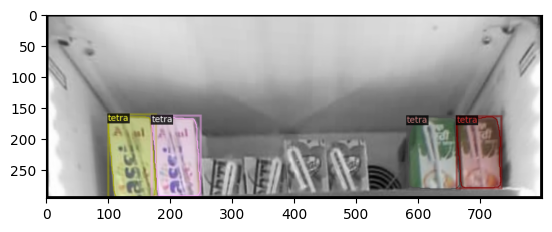

In [179]:
index = 0
shelf = chiller.shelves[index]
print([b.depth for b in shelf.bottles])
plt.imshow(shelf.bottle_image);

In [180]:
print([b.depth for b in shelf.bottles])
plt.figure(figsize=(10,10))
plt.imshow(shelf.depth_image);

[9.45073902027027, 9.654070945945946, 9.376651182432433, 10.149336993243242]


[5.120919642857143,
 8.205794642857143,
 0.3728660714285714,
 8.102174107142858,
 0.5026741071428571,
 10.047575892857143,
 7.712178571428572,
 7.212044642857143,
 7.188544642857143]

In [79]:
d.mean()

9.390887784090909

In [28]:
chiller.to_prodigy()

{'image': '/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set49-siteData-July16-July31-s3i2/batch00/VG16_1721371970757-f09.jpg',
 'path': '/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set49-siteData-July16-July31-s3i2/batch00/VG16_1721371970757-f09.jpg',
 'spans': [{'label': 'shelf1',
   'points': [[373, 325],
    [372, 326],
    [366, 326],
    [365, 327],
    [361, 327],
    [360, 328],
    [356, 328],
    [355, 329],
    [354, 329],
    [352, 331],
    [352, 333],
    [351, 334],
    [351, 335],
    [350, 336],
    [350, 338],
    [349, 339],
    [349, 341],
    [348, 342],
    [349, 343],
    [349, 346],
    [350, 347],
    [350, 350],
    [351, 351],
    [351, 353],
    [352, 354],
    [352, 356],
    [353, 357],
    [353, 359],
    [354, 360],
    [354, 361],
    [355, 362],
    [355, 364],
    [356, 365],
    [356, 366],
    [357, 367],
    [357, 372],
    [358, 373],
    [358, 379],
    [359, 380],
    [359, 383],
    [360, 384],
    [360

# Merging Folders

In [1]:
from pathlib import Path
import shutil

In [42]:
storewise_dir = Path('/media/akshay/datasets/coke/data/sales/sorted/August06-August10/storewise')
video_wise_dir = Path('/media/akshay/datasets/coke/data/sales/sorted/August06-August10/videowise')
dirs = [storewise_dir, video_wise_dir]

In [43]:
files = []
for d in dirs:
    files.extend(d.rglob("*.jpg"))

In [44]:
len(files)

26554

In [40]:
set([file.parent.name for file in files])

{'bottleinhand', 'certain', 'nonsales'}

## cleanup

In [36]:
completed = []
for file in files:
    if 'nosales' in file.parent.name:
        dir_path = file.parent
        if dir_path in completed:
            continue
        if not dir_path.is_dir():
            continue
        dir_path.rename(dir_path.parent / "nonsales")
        completed.append(dir_path)

In [31]:
file

PosixPath('/media/akshay/datasets/coke/data/sales/sorted/August06-August10/videowise/VG12_FCE8C0CE7E3C/FCE8C0CE7E3C_1723107316442_1319/nosales/FCE8C0CE7E3C_1723107316442_1319_00.jpg')

In [45]:
output_dir = Path('/media/akshay/datasets/coke/data/sales/sorted/August06-August10/final')

In [47]:
for file in files:
    output_path = output_dir / file.parent.name / f"{file.name}"
    if not output_path.parent.is_dir():
        output_path.parent.mkdir()
    shutil.copy(file, output_path)

## Undistort

In [72]:
from pathlib import Path
import shutil
from lensCorrector import LensCorrector
import cv2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
lens_corrector = LensCorrector()

In [74]:
input_dir = Path('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19')

In [75]:
input_files = sorted(list(input_dir.rglob("*.jpg")))

In [76]:
input_files[:5]

[PosixPath('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19/batch00/C82E18224378_1722917007254_8108_07.jpg'),
 PosixPath('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19/batch00/C82E18224378_1722917007254_8108_08.jpg'),
 PosixPath('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19/batch00/C82E18224378_1722917145168_8110_12.jpg'),
 PosixPath('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19/batch00/C82E18224378_1722917145168_8110_13.jpg'),
 PosixPath('/home/akshay/workspace/labelling/coke/datasets/200DLens/distorted/Set59-salesBottleInHand-September-19/batch00/C82E18224378_1722917145168_8110_14.jpg')]

In [77]:
for input_file in tqdm(input_files):
    output_file = Path(str(input_file).replace('distorted', 'undistorted'))
    if not output_file.parent.is_dir():
        output_file.parent.mkdir(parents=True)
    image, _, _ = lens_corrector.correct(input_file)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(output_file), image)    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [02:18<00:00, 19.43it/s]


In [71]:
# image = cv2.imread(str(input_file))


True

In [69]:
image.shape

(1599, 1199, 3)

In [70]:
plt.imshow(image);

# Sales

In [1]:
from classificationInference import FrameSelector
from analyzeVideos import VideoAnalyzer, VideoManager
from pathlib import Path

/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-20 08:35:47.180 | INFO     | shelfSettings:__init__:120 - Initializing StoreManager with raise_exception: True


In [2]:
man = VideoManager()

2024-09-20 08:35:47.559 | INFO     | analyzeVideos:load_frame:56 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoStats.parquet records: 219154 last modified: 2024-08-26 10:35:57.196381


In [3]:
video_path = Path('/media/akshay/datasets/coke/siteData/C82E18230DD8/20240816/C82E18230DD8_1723782285483_11714.avi')
man.get_video_status(video_path)

2024-09-20 08:35:48.946 | INFO     | analyzeVideos:get_video_status:113 - file: /C82E18230DD8/20240816/C82E18230DD8_1723782285483_11714.avi status: top3Clear


'top3Clear'

In [7]:
model_path = Path("/media/akshay/datasets/coke/models/sales/bottleInHand/frameSelection-September-19/salesFrameSelection.pth")
frame_selector = FrameSelector(model_path)

2024-09-20 09:19:57.360 | INFO     | classificationInference:__init__:57 - Loaded model: /media/akshay/datasets/coke/models/sales/bottleInHand/frameSelection-September-19/salesFrameSelection.pth with categories: ['bottleInHand', 'nonsales'] to: cuda:0


In [8]:
# video_path = Path('/media/akshay/datasets/coke/siteData/EC64C9A711F4/20240809/EC64C9A711F4_1723213781385_3216.avi')
video_path = Path('/media/akshay/datasets/coke/siteData/C82E18230DD8/20240816/C82E18230DD8_1723782285483_11714.avi')

In [9]:
result = frame_selector.select_from_video(video_path)

2024-09-20 09:20:05.350 | INFO     | classificationInference:select_frame:216 - [00]: category: bottleInHand     score: 0.59
2024-09-20 09:20:05.351 | INFO     | classificationInference:select_frame:216 - [01]: category: bottleInHand     score: 0.99
2024-09-20 09:20:05.351 | INFO     | classificationInference:select_frame:216 - [02]: category: bottleInHand     score: 0.88
2024-09-20 09:20:05.351 | INFO     | classificationInference:select_frame:216 - [03]: category: nonsales         score: 0.77
2024-09-20 09:20:05.351 | INFO     | classificationInference:select_frame:216 - [04]: category: bottleInHand     score: 0.92
2024-09-20 09:20:05.352 | INFO     | classificationInference:select_frame:216 - [05]: category: bottleInHand     score: 0.99
2024-09-20 09:20:05.352 | INFO     | classificationInference:select_frame:216 - [06]: category: bottleInHand     score: 0.86
2024-09-20 09:20:05.352 | INFO     | classificationInference:select_frame:216 - [07]: category: nonsales         score: 0.68


# Debug problems with SamConvertMaskToPolygon

In [34]:
from utils import ProdigyLoader, decode_image, ProdigyLoader
from pathlib import Path
from matplotlib import pyplot as plt
from prod

In [11]:
p = ProdigyLoader()

In [19]:
path = Path("/home/akshay/workspace/labelling/coke/datasets/exported/200DLens/September-20/salesMethod2-Set57/salesMethod2-set57-salesBottleInHand-September-09-batch00-reshma-part2.jsonl")

In [20]:
json_dicts, _ = p.load(path)

In [21]:
len(json_dicts)

7278

In [22]:
d = json_dicts[1]

In [23]:
d.keys()

dict_keys(['image', 'text', 'meta', 'path', '_input_hash', '_task_hash', '_is_binary', '_view_id', 'width', 'height', 'spans', 'status', 'answer', '_timestamp', '_annotator_id', '_session_id'])

[{'id': 'cdfd67d6-5f20-4488-ae8a-6f4788253a0f',
  'label': 'bottleInHand',
  'color': '#00ffff',
  'x': 775.3,
  'y': 788.7,
  'height': 182,
  'width': 64.7,
  'center': [807.65, 879.7],
  'type': 'rect',
  'points': [[775.3, 788.7], [775.3, 970.7], [840, 970.7], [840, 788.7]],
  'mask': ''}]
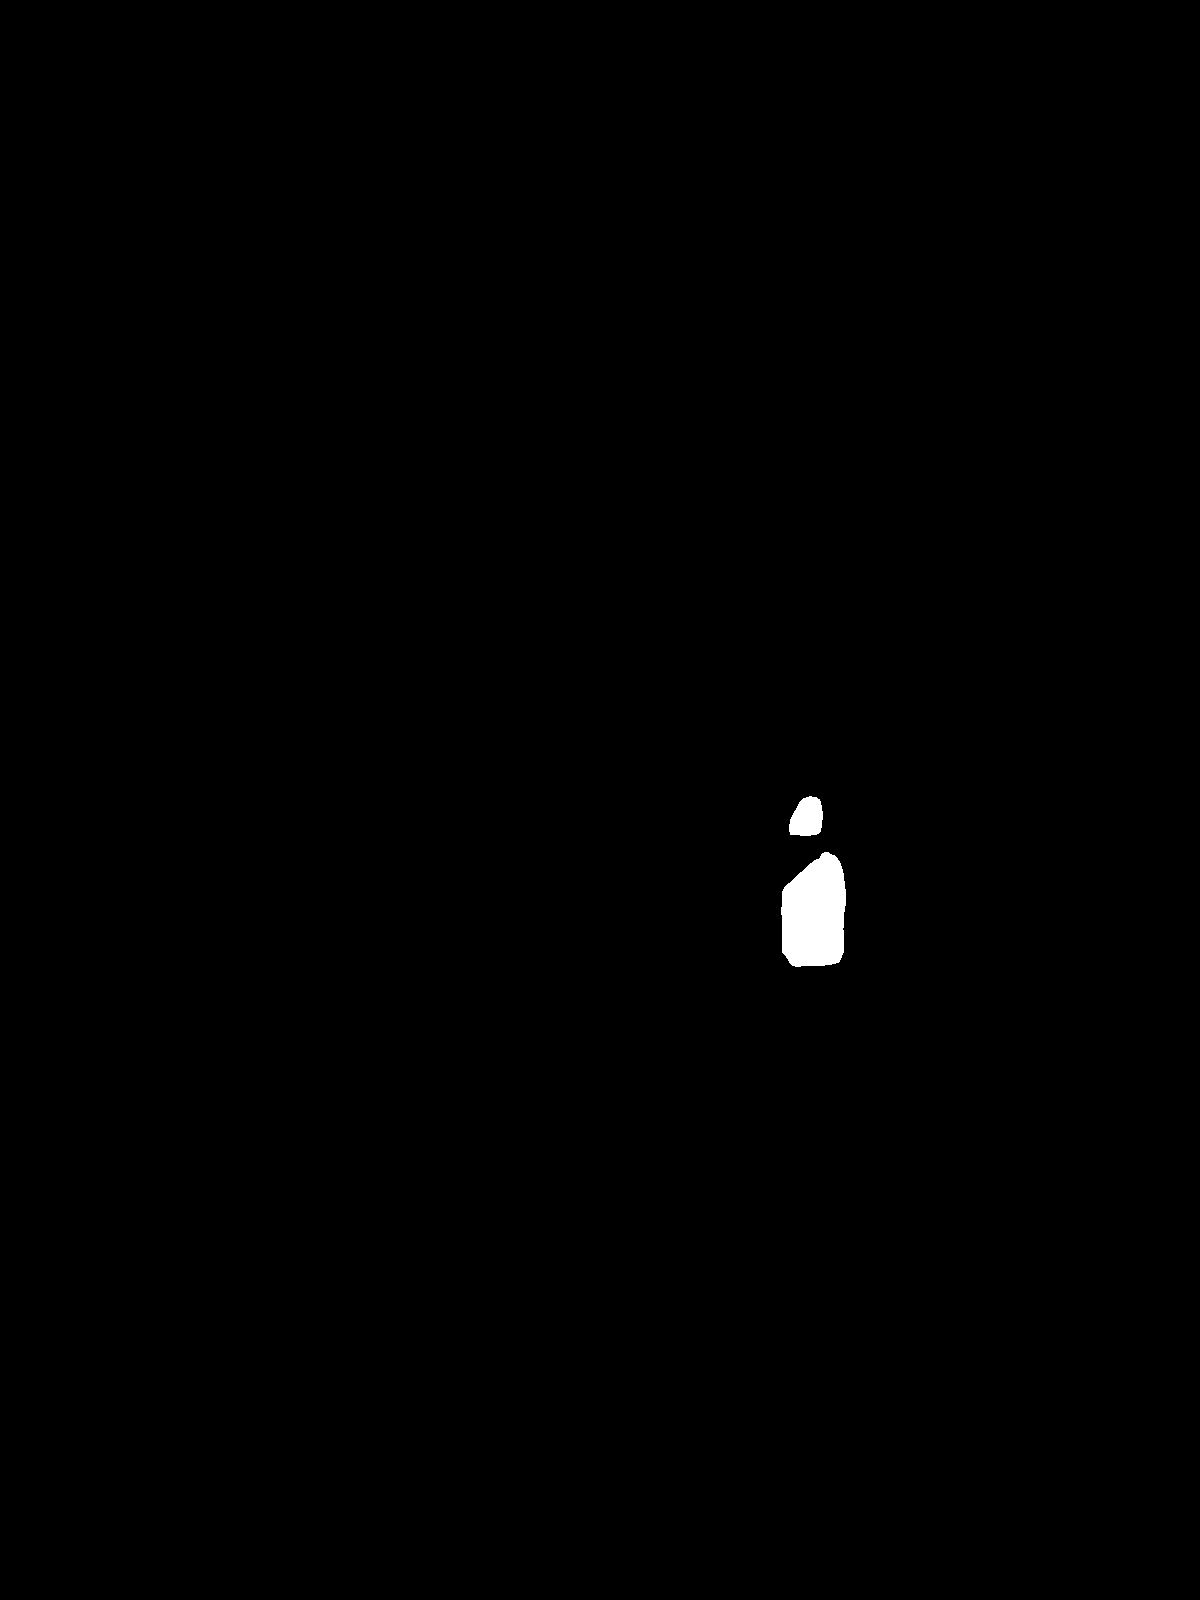

In [24]:
d['spans']

In [30]:
mask = d['spans'][0]['mask']

''
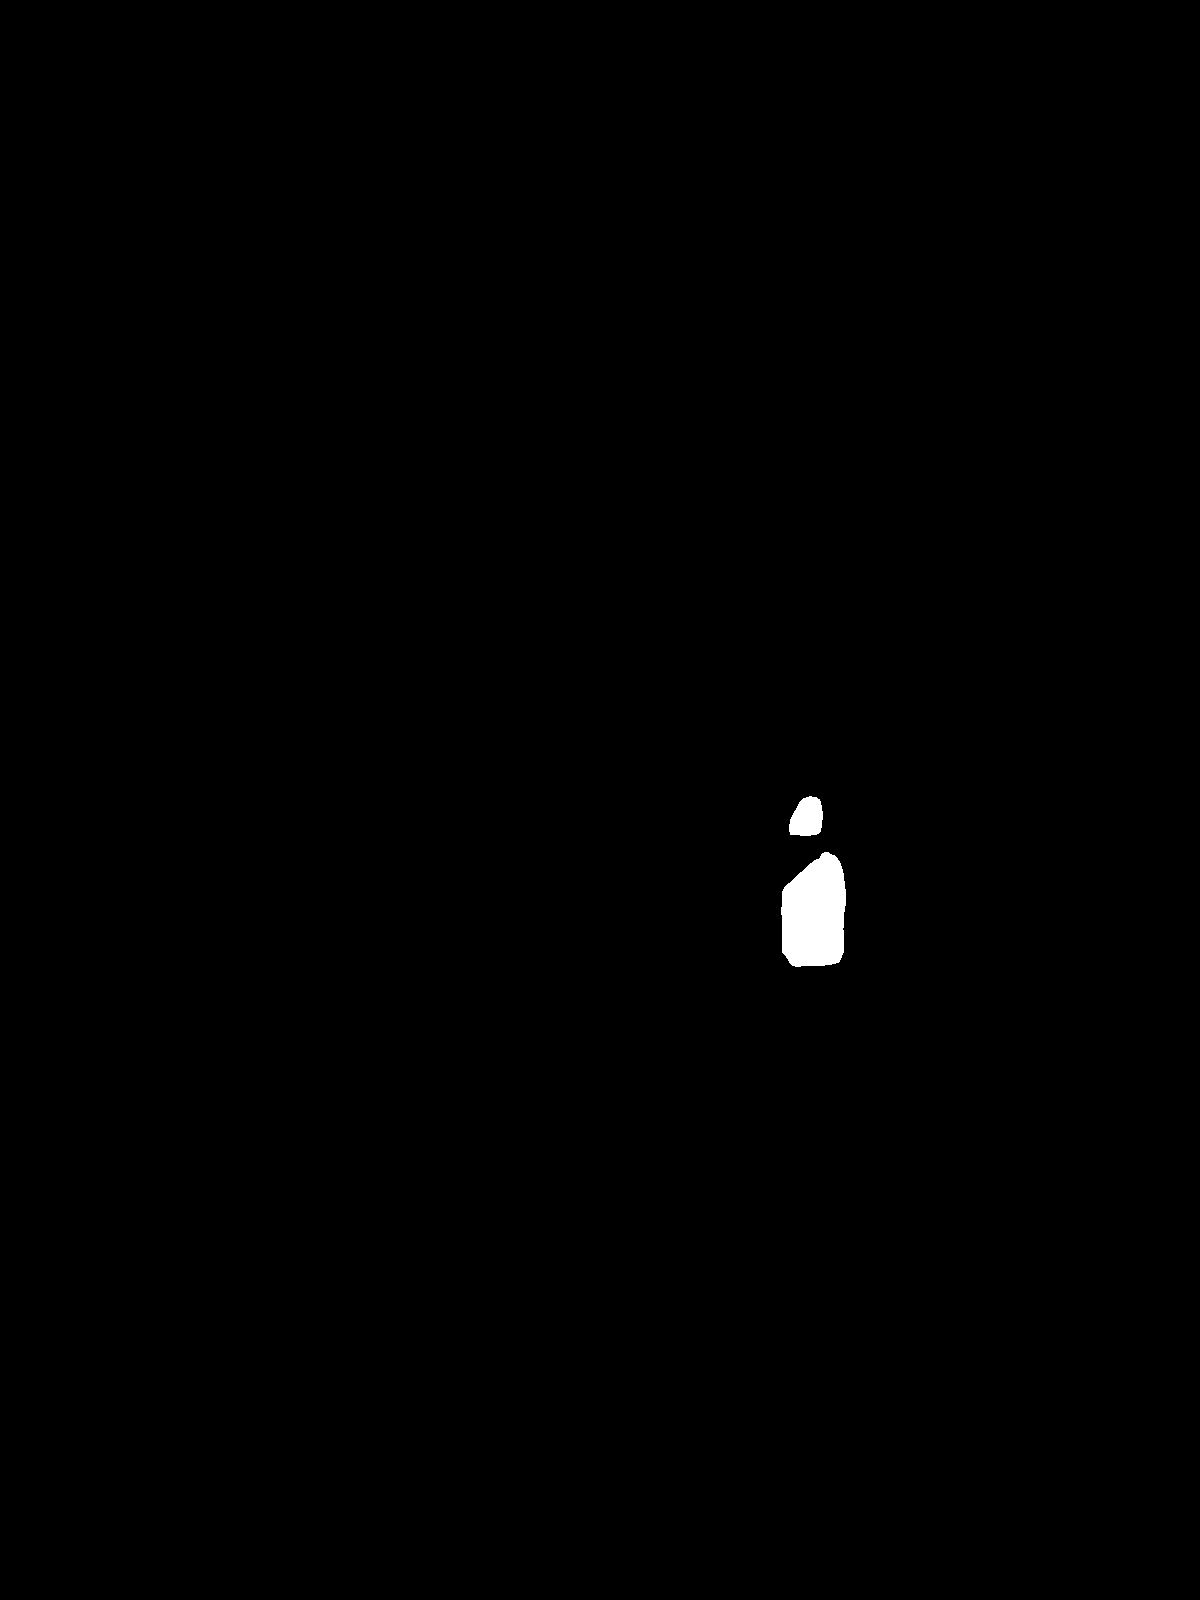

In [31]:
mask

In [33]:
m = decode_image(mask)

In [36]:
plt.imshow(m);